<a href="https://colab.research.google.com/github/palima1/text_processing/blob/main/C%C3%B3pia_de_01_ajustes_e_testes_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
!pip install contractions
!pip install textsearch
!pip install tqdm

In [172]:
#tratamentos iniciais
import pandas as pd
import numpy as np
#divisão dos dados
from sklearn.model_selection import train_test_split
#modelos baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
#text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
# from nltk.tokenize import sent_tokenize (Tokenization)
from nltk.probability import FreqDist
from nltk.metrics import ConfusionMatrix
#visualização 
from wordcloud import WordCloud
import random
from matplotlib import pyplot as plt
# CNN
import os 
from bs4 import BeautifulSoup
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

In [173]:
df = pd.read_csv('mouse.csv')

In [174]:
df.head()

,score,description,date
0,"1,0",O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,"5,0","Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,"3,0","A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,"5,0",A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,"1,0","O mouse está em boas condições, funcionando be...",21 de junho de 2020


# Pre-processing

### Contagem e remoção de dados nulos

In [175]:
df.isnull().sum()

score           0
description    18
date            0
dtype: int64

In [176]:
df.dropna(axis=0,inplace=True)

### Definição das categorias

In [177]:
def categoriza(dados):
    scores = []
    i = 0
    for dado in dados:
        if (dado == '1,0' or dado == '2,0'):
            scores.append(0)  #avaliação ruim
        if (dado =='3,0'):
            scores.append(1)  #avaliação ruim        
        if (dado == '4,0' or dado == '5,0'):
            scores.append(2) #avaliação boa
        i+=1
    return(scores)

In [178]:
df['score'] = categoriza(df['score'])

In [179]:
df

,score,description,date
0,0,O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,2,"Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,1,"A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,2,A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,0,"O mouse está em boas condições, funcionando be...",21 de junho de 2020
...,...,...,...
4812,2,A mídia não pôde ser carregada.,25 de março de 2022
4813,2,"ele é um pouco pequeno, mas tem uma resposta r...",23 de março de 2022
4814,2,"logitech né?! sem comentários, mouse maravilhoso",21 de março de 2022
4815,2,Muito bom e bonito,17 de janeiro de 2022


### Divisão dos dados

In [180]:
y = df['score']
x = df.iloc[:,1]

#divisão do treino e teste

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [181]:
y_train.value_counts()

2    3634
0     137
1      69
Name: score, dtype: int64

In [182]:
y_test.value_counts()

2    908
0     34
1     18
Name: score, dtype: int64

### Resolvendo o desbalanceamento dos dados de treino

In [183]:
from imblearn.over_sampling import RandomOverSampler

In [184]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

In [185]:
print(X_resampled.shape)
print(y_resampled.shape)
print('\n',pd.DataFrame(y_resampled).value_counts())

(10902, 1)
(10902,)

 0    3634
1    3634
2    3634
dtype: int64


In [186]:
X_train , y_train = pd.DataFrame(X_resampled), y_resampled

In [187]:
X_train = np.array(X_train[0])

### Tokenização

In [188]:
def tokenizador(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [189]:
X_train = tokenizador(X_train)
X_test = tokenizador(X_test)

### Padronização de algumas escritas

In [190]:
def padroniza_caracteres(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [191]:
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também',
            'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo',
            'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [192]:
X_train = padroniza_caracteres(X_train,std_list)
X_test = padroniza_caracteres(X_test,std_list)

### Remoção de stop words

In [193]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [194]:
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

In [195]:
pontos = ['!','.',',',':',';']

for sinal in pontos:
    nltk_stopwords.append(sinal)

In [196]:
nltk_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [197]:
def removedor_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [198]:
X_train = removedor_stopwords(X_train, nltk_stopwords)
X_test = removedor_stopwords(X_test, nltk_stopwords)

# Stemmer

In [199]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [200]:
def aplica_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [201]:
X_train_stem = aplica_stemmer(X_train)
X_test_stem = aplica_stemmer(X_test)

### Visualizações iniciais

In [202]:
def texto_para_cloud(tokens):
    text = ''

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            text += word + ' '
        
    return text

In [203]:
x2=tokenizador(x)

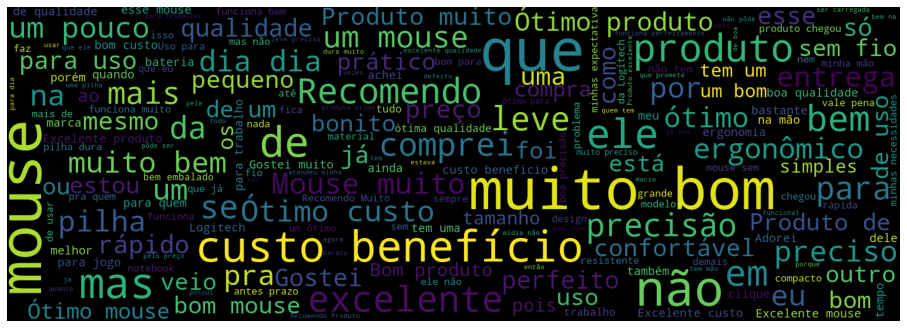

In [204]:
text_cloud = texto_para_cloud(random.sample(x2, 3000))

word_cloud = WordCloud(max_font_size = 100, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (16, 9))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Frequencias

In [205]:
def pega_freq(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)

    return ls

In [206]:
# Frequency Distribution on training dataset
fd_list = pega_freq(X_train_stem)
fdist = FreqDist(fd_list)
print(fdist)

# most common words
most_common = fdist.most_common(25)
print(most_common,'\n')

<FreqDist with 2288 samples and 162845 outcomes>
[('mous', 6590), ('produt', 3720), ('compr', 2802), ('bom', 2415), ('uso', 2387), ('bem', 1876), ('precis', 1754), ('funcion', 1685), ('vei', 1415), ('func', 1318), ('marc', 1264), ('dia', 1262), ('pilh', 1238), ('mes', 1189), ('problem', 1178), ('us', 1161), ('gost', 1151), ('rol', 1067), ('pouc', 1052), ('pra', 1039), ('ótim', 998), ('scroll', 991), ('(', 990), ('defeit', 988), ('outr', 950)] 



In [207]:
most_uncommon = fdist.hapaxes()
print(most_uncommon[0:30])

['rt', 'gratific', 'aloj', 'ergônom', 'dhl', 'facíl', 'aaaa', 'daí', 'lasq', 'beste', 'recompens', '.,', 'ninguém', 'minuscul', 'típic', 'desemprenh', 'afim', 'tem', 'curvat', 'reflet', 'necessari', 'nan', 'seleç', 'honr', 'vlw', 'ultim', 'empenh', 'cãibr', 'crianç', 'net']


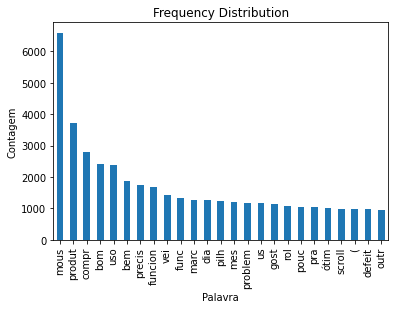

In [208]:
# print most common words
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Frequency Distribution')
ax.set_xlabel('Palavra')
ax.set_ylabel('Contagem')
plt.show()

# Destransformando
- Após o tratamento dos dados, com o uso do nltk, voltaremos os mesmos para o formato inicial, de string

In [209]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [210]:
X_train = _untokenize_text(X_train)
X_test = _untokenize_text(X_test)

In [211]:
X_train_stem = _untokenize_text(X_train_stem)
X_test_stem = _untokenize_text(X_test_stem)

## Baseline - Bag of words/Naive Bayes

In [212]:
vetores = CountVectorizer()
#vetores2 = CountVectorizer()

In [213]:
X_train = vetores.fit_transform(X_train)
X_train = X_train.toarray()

In [214]:
X_test = vetores.transform(X_test)
X_test =  X_test.toarray()

print(X_train.shape)
print(X_test.shape)

(10902, 3736)
(960, 3736)


In [215]:
print(X_train.shape)
print(X_test.shape)

(10902, 3736)
(960, 3736)


In [216]:
modelo_1 = MultinomialNB()
modelo_1.fit(X_train,y_train)

MultinomialNB()

In [217]:
predict = modelo_1.predict(X_test)

In [218]:
metrics.accuracy_score(predict, y_test)

0.9229166666666667

In [219]:
test = ['Melhor mouse do brasil',
       'Péssimo mouse horrivel',
       'mais ou menos, mas dá pra usar',
       'compensa, entrega o que promete, mas nada muito além disso']

In [220]:
test = tokenizador(test)
test = padroniza_caracteres(test, std_list)
test = removedor_stopwords(test,nltk_stopwords)
test = _untokenize_text(test)

In [221]:
vetor_test = vetores.transform(test)
vetor_test = vetor_test.toarray()

In [222]:
vetor_test.shape

(4, 3736)

In [223]:
modelo_1.predict(vetor_test)

array([2, 0, 0, 2])

In [224]:
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.46      0.53      0.49        34
           1       0.07      0.11      0.09        18
           2       0.97      0.95      0.96       908

    accuracy                           0.92       960
   macro avg       0.50      0.53      0.51       960
weighted avg       0.94      0.92      0.93       960



In [225]:
resultados = cross_val_score(modelo_1, X_train, y_train, cv = 10)

In [226]:
print(resultados)

[0.96700275 0.9532539  0.95504587 0.96146789 0.96238532 0.95137615
 0.9559633  0.95779817 0.95137615 0.96238532]


## Random Forest

In [227]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

In [228]:
forest.fit(X_train,y_train)

RandomForestClassifier()

In [229]:
print(metrics.classification_report(y_test,forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.21      0.30        34
           1       0.00      0.00      0.00        18
           2       0.96      1.00      0.98       908

    accuracy                           0.95       960
   macro avg       0.51      0.40      0.43       960
weighted avg       0.93      0.95      0.93       960



In [230]:
(98+0+34)/3

44.0

## LSTM

In [231]:
import tensorflow as tf
from keras.datasets import mnist

In [232]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [233]:
# Analisando os shapes
print("X_train: {0}".format(X_train.shape))
print("y_train: {0}".format(y_train.shape))
print("X_test: {0}".format(X_test.shape))
print("y_test: {0}".format(y_test.shape))

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


In [234]:
# Visualizando os labels
import numpy as np
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [235]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input

model = Sequential()

# Defina a camada escondida, utilize 'relu' como função de ativação
model.add(LSTM(100, input_shape=(28, 28), activation='tanh'))

# Outras camadas adicionais
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation = "relu"))

# Defina a camada de saída, utilize 'softmax' como função de ativação
# O número de neurônios na camada de saída será o número de labels
# no caso do mnist = 10
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               51600     
                                                                 
 dense_6 (Dense)             (None, 200)               20200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 10)               

In [236]:
model.compile(
 optimizer = "adam",
 loss = "sparse_categorical_crossentropy",
 metrics = ["accuracy"]
)

In [237]:
results = model.fit(
 X_train, y_train,
 epochs= 10,
 batch_size = 1000,
 validation_data = (X_test, y_test)
)

Epoch 1/10
60/60 [==============================] - 27s 418ms/step - loss: 1.5612 - accuracy: 0.4313 - val_loss: 0.8089 - val_accuracy: 0.7177
Epoch 2/10
60/60 [==============================] - 26s 440ms/step - loss: 0.7178 - accuracy: 0.7485 - val_loss: 0.5395 - val_accuracy: 0.8093
Epoch 3/10
60/60 [==============================] - 24s 407ms/step - loss: 0.5324 - accuracy: 0.8207 - val_loss: 0.4402 - val_accuracy: 0.8479
Epoch 4/10
60/60 [==============================] - 24s 396ms/step - loss: 0.4436 - accuracy: 0.8520 - val_loss: 0.3924 - val_accuracy: 0.8658
Epoch 5/10
60/60 [==============================] - 23s 391ms/step - loss: 0.3920 - accuracy: 0.8698 - val_loss: 0.3552 - val_accuracy: 0.8770
Epoch 6/10
60/60 [==============================] - 24s 401ms/step - loss: 0.3471 - accuracy: 0.8851 - val_loss: 0.3317 - val_accuracy: 0.8844
Epoch 7/10
60/60 [==============================] - 24s 396ms/step - loss: 0.3147 - accuracy: 0.8964 - val_loss: 0.3107 - val_accuracy: 0.8969

## CNN

### Prepare Train Test Split

In [238]:
# build train and test datasets
reviews = df['description'].values
sentiments = df['score'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

## Text Wrangling & Normalization

In [239]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [240]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 4800/4800 [00:00<00:00, 6240.80it/s]
0it [00:00, ?it/s]

CPU times: user 785 ms, sys: 49.6 ms, total: 834 ms
Wall time: 794 ms


## Preprocessing

In [241]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [242]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('desconfortavelindicaria', 4737), ('<PAD>', 0), 1)

In [243]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [244]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

### Sequence Normalization

In [245]:
MAX_SEQUENCE_LENGTH = 1000

In [246]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((4800, 1000), (0, 1000))

### Encoding Labels

In [247]:
le = LabelEncoder()
num_classes=2 # positive -> 2, negative -> 1, negative -> 0

In [248]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [249]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

In [250]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [251]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         1421400   
                                                                 
 conv1d_3 (Conv1D)           (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 500, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 250, 32)          

## Model Training

In [252]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
34/34 [==============================] - 103s 3s/step - loss: -13673.7295 - accuracy: 0.0194 - val_loss: -128621.0703 - val_accuracy: 0.0125
Epoch 2/2
34/34 [==============================] - 102s 3s/step - loss: -5080909.0000 - accuracy: 0.0188 - val_loss: -25281050.0000 - val_accuracy: 0.0125


## Model Evaluation

In [268]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

In [254]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

AttributeError: ignored

In [259]:
predictions = ['positive' if item == 2 else 'negative' for item in predictions]
predictions[:10]

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)